In [77]:
# Importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
from wordcloud import WordCloud, ImageColorGenerator #Nube de palabras y colores para las palabras en la nube
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento

In [68]:
file_names = ["../input/delitos.csv", "../input/no_delitos_limpio.csv","../input/tweets-delitos-otro_grupo.csv"]

df = pd.concat([pd.read_csv(name, usecols=['Content', 'Delito']) for name in file_names])

In [69]:
df

,Content,Delito
0,Desde las cámaras de videovigilancia observamo...,1
1,Desde las cámaras de videovigilancia captamos ...,1
2,Desde las cámaras de videovigilancia realizamo...,1
3,Un vehículo reportado como robado fue captado ...,1
4,#Alerta | Miembros de la \r\n@ATM_Transito\r\n...,1
...,...,...
302,Un cuerpo desmembrado y embalado fue encontrad...,1
303,Delincuentes asaltaron en un local de ropa ubi...,1
304,Delincuente fue neutralizado cuando intentó ro...,1
305,Delincuentes destrozaron un negocio porque el ...,1


In [70]:
text = " ".join(df["Content"])
text = text.lower()

In [71]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pengu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pengu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [73]:
stops = stopwords.words("spanish")

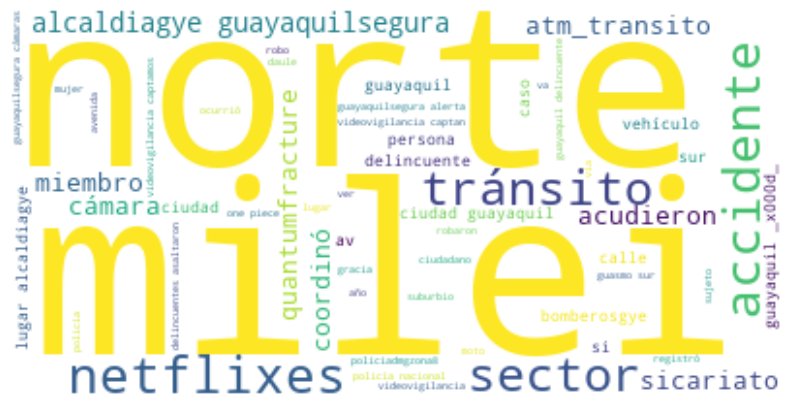

In [74]:
# Generar y mostrar una nube de palabras
wc = WordCloud(stopwords=stops, background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
# Definir la función de preprocesamiento
def preprocessing(text):
    # Inicializar el Snowball Stemmer para español
    stemmer = SnowballStemmer("spanish")
    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)
    # Eliminar menciones
    text = re.sub(r'@\w+', '', text)
    # Eliminar hashtags
    text = re.sub(r'#', '', text)
    # Eliminar caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)
    # Convertir texto a minúsculas
    text = text.lower()
    # Tokenizar el texto
    words = word_tokenize(text)
    # Eliminar stopwords y aplicar stemming
    words = [stemmer.stem(word) for word in words if word not in stopwords.words('spanish')]
    # Unir las palabras procesadas en una oración
    return ' '.join(words)

In [40]:
text = preprocessing(text)

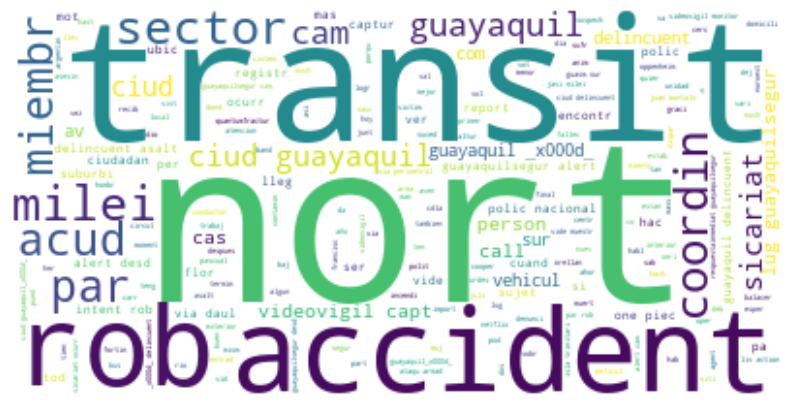

In [41]:
# Generar y mostrar una nueva nube de palabras después del preprocesamiento
wc = WordCloud(stopwords=stops, background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [42]:
df['Content'] = df['Content'].apply(preprocessing)

In [44]:
df['Delito'].value_counts()

1    859
0    530
Name: Delito, dtype: int64

In [46]:
# Submuestreo de la clase mayoritaria "Delito" para balancear las clases
dfn = df.loc[df["Delito"] == 0]
dfd = df.loc[df["Delito"] == 1]

In [47]:
dfd = dfd.sample(n=530, random_state=20)

In [48]:
df = pd.concat([dfd, dfn])
df["Delito"].value_counts()

1    530
0    530
Name: Delito, dtype: int64

In [50]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = df['Content']
y = df['Delito']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo y Resultados

In [51]:
# Vectorizar los datos de texto utilizando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [54]:
X_train_tfidf.toarray().shape

(742, 2860)

In [55]:
X_test_tfidf.toarray().shape

(318, 2860)

In [56]:
# Reducción de dimensionalidad mediante PCA
pca = PCA(n_components=500)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [57]:
sum(pca.explained_variance_ratio_)

0.9260779776873306

In [61]:
# Inicializar y entrenar un clasificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [62]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test_pca)

# Evaluar el modelo Random Forest
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

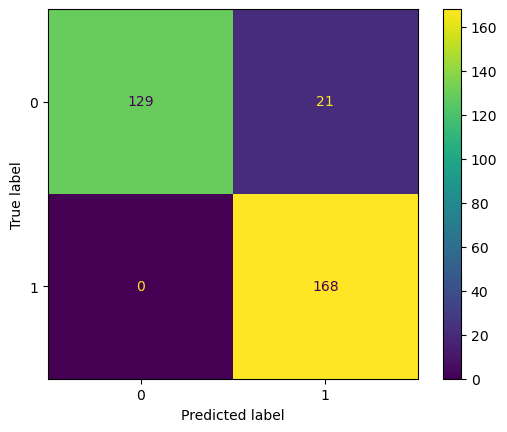

In [65]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

## ¿Cómo se desempeña el modelo en términos de precisión, recall y F1-score para las clases "Delito" y "No Delito"?

In [83]:
# Reporte de la clasificación
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       150
           1       0.89      1.00      0.94       168

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.94      0.93      0.93       318



El informe de clasificación proporciona métricas de rendimiento para su modelo de clasificación en las clases "Delito" (1) y "No Delito" (0). Aquí están los resultados:

Para la clase "No Delito" (0):

    Precisión: 1.00
    Recall: 0.86
    F1-score: 0.92

Para la clase "Delito" (1):

    Precisión: 0.89
    Recall: 1.00
    F1-score: 0.94

Los resultados indican que el modelo tiene un rendimiento destacado en ambas clases. Es especialmente preciso al predecir la clase "No Delito" y logra identificar todos los casos de "Delito" de manera perfecta.

La precisión promedio ponderada (weighted avg) del 94% muestra un equilibrio adecuado entre precisión y recall en general. La precisión promedio no ponderada (macro avg) también es del 94%, lo que resalta el sólido rendimiento del modelo en ambas clases.

En resumen, el modelo parece ser altamente efectivo para clasificar tweets como "Delito" y "No Delito". Sus altos valores de precisión y recall en ambas clases sugieren que puede ser una herramienta útil para detectar tweets relacionados con actividades delictivas en Guayaquil.